In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.contrib.distributions as dist
import tensorflow.contrib.bayesflow as bf
import matplotlib.pyplot as plt
%matplotlib inline

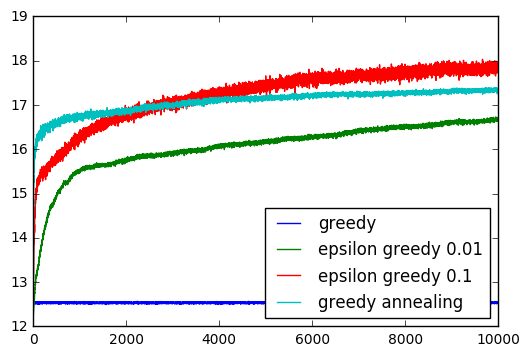

In [5]:
bandit_count = 1000
batch_size = 1000
batch_indices = np.arange(batch_size)
iterations = 10000

mean = np.random.uniform(5, 20, size=(batch_size, bandit_count))
stddev = np.random.uniform(0, 1, size=(batch_size, bandit_count))

def greedy(sample_mean, iteration):
    return np.argmax(sample_mean, axis=1)

def epsilon_greedy(sample_mean, iteration, epsilon):
    should_explore = np.random.binomial(n=1, p=epsilon, size=(batch_size))
    greedy_choice = np.argmax(sample_mean, axis=1)
    random_choice = np.random.choice(bandit_count, size=(batch_size))
    return np.where(should_explore, random_choice, greedy_choice)

def greedy_annealing(sample_mean, iteration):
    should_explore = np.random.binomial(n=1, p=1/(1+iteration)**(1/2), size=(batch_size))
    greedy_choice = np.argmax(sample_mean, axis=1)
    random_choice = np.random.choice(bandit_count, size=(batch_size))
    return np.where(should_explore, random_choice, greedy_choice)

def simulate_bandits(strategy, **kwargs):
    sample_total = np.random.uniform(-1e-6, 1e-6, size=(batch_size, bandit_count))
    bandit_sampled_times = np.ones(shape=(batch_size, bandit_count))
    rewards = np.zeros(shape=(iterations, batch_size))
    for i in range(iterations):
        bandit_choice = strategy(sample_total / bandit_sampled_times, i, **kwargs)
        chosen_mean = mean[batch_indices, bandit_choice]
        chosen_stddev = stddev[batch_indices, bandit_choice]
        uniform = np.random.uniform(-1.0, 1.0, size=(batch_size))
        sample = uniform * chosen_stddev + chosen_mean
        sample_total[batch_indices, bandit_choice] += sample
        bandit_sampled_times[batch_indices, bandit_choice] += 1
        rewards[i,:] = sample
    return np.mean(rewards, axis=1)

plt.plot(np.arange(iterations), simulate_bandits(greedy), label='greedy')
plt.plot(np.arange(iterations), simulate_bandits(epsilon_greedy, epsilon=0.01), label='epsilon greedy 0.01')
plt.plot(np.arange(iterations), simulate_bandits(epsilon_greedy, epsilon=0.1), label='epsilon greedy 0.1')
plt.plot(np.arange(iterations), simulate_bandits(greedy_annealing), label='greedy annealing')
plt.legend(loc='lower right')
plt.show()

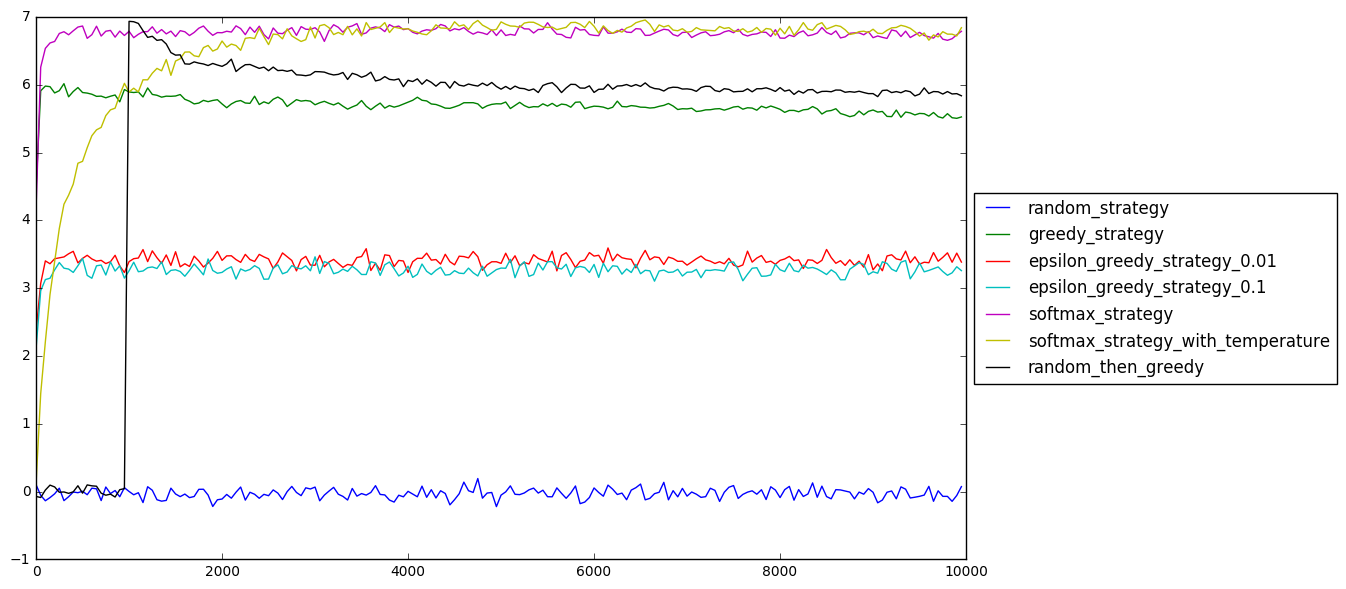

In [44]:
tf.reset_default_graph()

# Problem parameters.
max_iterations = 10000
plot_points = 200
bandit_count = 10
batch_size = 1000

# Sample Bandit reward distributions.
reward_mean = dist.Uniform(-10.0, 10.0).sample(batch_size * bandit_count)
reward_stddev = dist.Uniform(0.0, 100.0).sample(batch_size * bandit_count)
reward_dist = dist.Uniform(reward_mean - reward_stddev/2, reward_mean + reward_stddev/2)

def random_strategy(reward_mean, iteration):
    """Returns a random action."""
    uniform_real = dist.Uniform(0.0, tf.cast(bandit_count, tf.float32))
    return tf.cast(tf.floor(uniform_real.sample(batch_size)), tf.int32)

def greedy_strategy(reward_mean, iteration):
    """Always selects the action with the highest mean value."""
    return tf.cast(tf.argmax(reward_mean, dimension=1), tf.int32)

def epsilon_greedy_strategy(epsilon):
    """Randomly explores with probability epsilon, greedy otherwise."""
    should_explore = dist.Bernoulli(epsilon)
    def strategy(*args, **kwargs):
        return tf.select(
            tf.cast(should_explore.sample(batch_size), tf.bool),
            random_strategy(*args, **kwargs),
            greedy_strategy(*args, **kwargs))
    return strategy

def softmax_strategy(reward_mean, iteration):
    """Randomly selects actions with softmax."""
    return dist.Categorical(logits=reward_mean).sample()

def softmax_strategy_with_temperature(reward_mean, iteration):
    """Randomly selects actions with softmax with changing temperature."""
    logits = reward_mean * tf.sqrt(
        tf.cast(iteration, tf.float32) + 1) / 1e2
    return dist.Categorical(logits=logits).sample()

def random_then_greedy(reward_mean, iteration):
    return tf.cond(
        iteration < 1000,
        lambda: random_strategy(reward_mean, iteration),
        lambda: greedy_strategy(reward_mean, iteration))

def softmax_then_greedy(reward_mean, iteration):
    return tf.cond(
        iteration < 1000,
        lambda: softmax_strategy_with_temperature(reward_mean, iteration),
        lambda: greedy_strategy(reward_mean, iteration))

def epsilon_greedy_softmax_strategy(reward_mean, iteration):
    """Randomly explores using softmax with some probability, greedy otherwise."""
    should_explore = dist.Bernoulli(0.01)
    return tf.select(
        tf.cast(should_explore.sample(batch_size), tf.bool),
        softmax_strategy_with_temperature(reward_mean, iteration),
        greedy_strategy(reward_mean, iteration))

def complex_strategy(reward_mean, iteration):
    should_explore = dist.Bernoulli(0.5)
    return tf.cond(
        iteration < 1000,
        lambda: tf.select(
            tf.cast(should_explore.sample(batch_size), tf.bool),
            softmax_strategy_with_temperature(reward_mean, iteration),
            greedy_strategy(reward_mean, iteration)),
        lambda: greedy_strategy(reward_mean, iteration))

def simulate_bandits(strategy, name):
    with tf.variable_scope(name):
        # The total reward starts with a small initial bias to shake up the
        # initial decisions.
        reward_initial_noise = dist.Uniform(-1e-3, 1e-3).sample([batch_size * bandit_count])
        reward_total = tf.Variable(
            reward_initial_noise, name="reward_total")

        # Every bandit starts with one "try" to prevent dividing by 0. This
        # doesn't affect the mean in the long term.
        bandit_tries = tf.Variable(
            tf.ones(batch_size * bandit_count), name="bandit_tries")
        
        # Collect mean rewards for each iteration.
        mean_rewards = tf.TensorArray(
            dtype=tf.float32, size=max_iterations, name="mean_rewards")
        
        # Loops are not very convenient to write.
        def condition(i, mean_rewards):
            return i < max_iterations
        
        def simulation_step(i, mean_rewards):
            # Choose the action.
            reward_mean = tf.reshape(reward_total, [batch_size, bandit_count])
            action = strategy(reward_mean, iteration=i)
            indices = action + np.arange(batch_size) * bandit_count
            
            # Compute the rewards and write the mean reward.
            reward = tf.gather(reward_dist.sample(), indices)
            mean_rewards = mean_rewards.write(i, tf.reduce_mean(reward))
            
            # Update the stats.
            alpha = 0.1
            delta = reward - tf.gather(reward_total, indices)
            reward_total_updated = tf.scatter_add(
                reward_total, indices, alpha * delta)
            
            # Enforce that the variable updates are executed before the
            # next loop iteration.
            with tf.control_dependencies([
                    reward_total_updated]):
                return i+1, mean_rewards

        _, mean_rewards = tf.while_loop(
            condition, simulation_step, [0, mean_rewards])
        
        rewards_per_plot_point = tf.reshape(mean_rewards.pack(), [plot_points, -1])
        return tf.reduce_mean(rewards_per_plot_point, 1)

# List of strategies to try.
strategies = [
    (random_strategy, 'random_strategy'),
    (greedy_strategy, 'greedy_strategy'),
    (epsilon_greedy_strategy(0.01), 'epsilon_greedy_strategy_0.01'),
    (epsilon_greedy_strategy(0.1), 'epsilon_greedy_strategy_0.1'),
    (softmax_strategy, 'softmax_strategy'),
    (softmax_strategy_with_temperature, 'softmax_strategy_with_temperature'),
    (random_then_greedy, 'random_then_greedy'),
    (softmax_then_greedy, 'softmax_then_greedy'),
    (epsilon_greedy_softmax_strategy, 'epsilon_greedy_softmax_strategy'),
    (complex_strategy, 'complex_strategy'),
]

# Create the graph ops for these strategies.
reward_ops = [simulate_bandits(*args) for args in strategies]

with tf.Session() as session:
    session.run(tf.initialize_all_variables())
    rewards = session.run(reward_ops)
    fig = plt.figure(figsize=(15, 7))
    ax = plt.subplot(111)
    for i, (_, name) in enumerate(strategies):
        scale_factor = max_iterations/plot_points
        plt.plot(np.arange(plot_points) * scale_factor, rewards[i], label=name)
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()